In [1]:
import statsmodels
import statsmodels.tsa.arima.model
import scipy
import scipy.stats
import matplotlib.pyplot as plt

## AR(1)

In [2]:
import numpy as np
np.random.seed(12345)
arparams = np.array([.4])
maparams = np.array([])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = statsmodels.tsa.arima_process.arma_generate_sample(ar, ma, 250)
model = statsmodels.tsa.arima.model.ARIMA(y, order=(1, 0, 0)).fit()
model.params

array([-0.04989985,  0.49616834,  0.98459052])

In [3]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -352.937
Date:                Mon, 02 Aug 2021   AIC                            711.875
Time:                        14:13:37   BIC                            722.439
Sample:                             0   HQIC                           716.127
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0499      0.125     -0.400      0.689      -0.294       0.195
ar.L1          0.4962      0.055      9.056      0.000       0.389       0.604
sigma2         0.9846      0.092     10.712      0.000       0.804       1.165
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.96   Prob(JB):                         0.87
Heteroskedasticity (H):               0.91   Skew:                             0.04
Prob(H) (two-sided):                  0.67   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [4]:
import numpyro
import jax

numpyro.set_host_device_count(4)

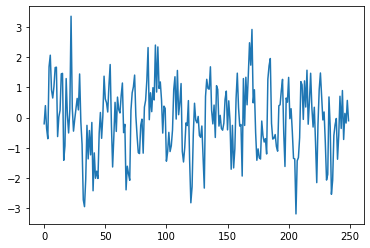

In [5]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(y)), y);

In [6]:
def ar1(y):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    mu = numpyro.sample(
        'mu',
        numpyro.distributions.Normal(0, 1),
    )
    
    sigma = numpyro.sample(
        'sigma',
        numpyro.distributions.HalfNormal(1),
    )
    
    def forward_one_step(y_1, next_y):
        err = next_y - (alpha*y_1)
        return next_y, err

    err_0 = y[0] - mu
    _, err = jax.lax.scan(forward_one_step, y[0], y[1:])
    err = jax.numpy.concatenate([err_0[jax.numpy.newaxis], err])
        
    numpyro.sample(
        'obs',
        numpyro.distributions.Normal(0, sigma),
        obs=err,
    )

In [7]:
sampler = numpyro.infer.NUTS(ar1)
mcmc = numpyro.infer.MCMC(sampler, num_samples=1000, num_warmup=1000, num_chains=4)
mcmc.run(jax.random.PRNGKey(0), y=y)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [8]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.50      0.05      0.50      0.40      0.58   3726.77      1.00
        mu     -0.11      0.70     -0.11     -1.33      0.95   3646.43      1.00
     sigma      1.00      0.04      1.00      0.92      1.07   3728.67      1.00

Number of divergences: 0


In [9]:
steps = 10
y_pred = np.ones((4000, len(y)+steps))*np.hstack([y, np.zeros(steps)])

In [10]:
trace = mcmc.get_samples()
for t in range(len(y), len(y)+steps):
    pred = scipy.stats.norm(trace['alpha']*y_pred[:, t-1], trace['sigma']).rvs(len(trace['sigma']))
    y_pred[:, t] = pred

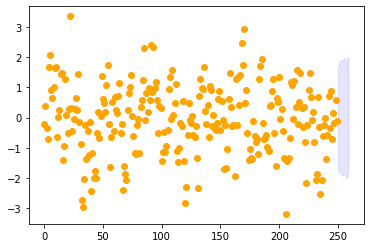

In [11]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(y)), y, 'o', color='orange');
ax.fill_between(np.arange(len(y), len(y)+steps), *numpyro.diagnostics.hpdi(y_pred[:, -steps:]), alpha=.1, color='blue');

## ARIMA(1, 0, 1)

In [12]:
import numpy as np
np.random.seed(12345)
arparams = np.array([.4])
maparams = np.array([.7])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = statsmodels.tsa.arima_process.arma_generate_sample(ar, ma, 250, scale=.01)
model = statsmodels.tsa.arima.model.ARIMA(y, order=(1, 0, 1)).fit()
model.params

array([-8.48227902e-04,  5.05502209e-01,  6.80811237e-01,  9.83147853e-05])

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 797.802
Date:                Mon, 02 Aug 2021   AIC                          -1587.603
Time:                        14:13:45   BIC                          -1573.518
Sample:                             0   HQIC                         -1581.934
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.002     -0.397      0.691      -0.005       0.003
ar.L1          0.5055      0.059      8.506      0.000       0.389       0.622
ma.L1          0.6808      0.052     13.055      0.000       0.579       0.783
sigma2      9.831e-05   9.15e-06     10.746      0.000    8.04e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.25
Prob(Q):                              0.92   Prob(JB):                         0.88
Heteroskedasticity (H):               0.91   Skew:                             0.03
Prob(H) (two-sided):                  0.68   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
def arma(y):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    phi = numpyro.sample(
        'phi',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    mu = numpyro.sample(
        'mu',
        numpyro.distributions.Normal(0, 1),
    )
    
    sigma = numpyro.sample(
        'sigma',
        numpyro.distributions.HalfNormal(1),
    )
    
    def transition_fn(carry, next_y):
        last_err, last_y = carry
        err = next_y - (alpha * last_y + phi * last_err)
        return (err, next_y), err

    err_0 = y[0] - (mu + phi*mu)
    _, err = jax.lax.scan(transition_fn, (err_0, y[0]), y[1:])
    err = jax.numpy.concatenate([err_0[jax.numpy.newaxis], err])
    numpyro.sample("err", numpyro.distributions.Normal(0, sigma), obs=err)

In [15]:
sampler = numpyro.infer.NUTS(arma)
mcmc = numpyro.infer.MCMC(sampler, num_samples=1000, num_warmup=1000, num_chains=4)
mcmc.run(jax.random.PRNGKey(0), y=y)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.51      0.06      0.52      0.41      0.62   3094.09      1.00
        mu     -0.00      0.00     -0.00     -0.01      0.01   4082.69      1.00
       phi      0.67      0.06      0.67      0.57      0.76   3163.44      1.00
     sigma      0.01      0.00      0.01      0.01      0.01   3978.25      1.00

Number of divergences: 0


In [17]:
steps=10
y_pred = np.ones((4000, len(y)+steps))*np.hstack([y, np.zeros(steps)])

In [18]:
steps = 10
trace = mcmc.get_samples()
for t in range(len(y), len(y)+steps):
    # mu = alpha*y_1 + phi*err_1
    err_1 = y_pred[:, t-1] - (trace['alpha'])
    pred = scipy.stats.norm(
        (
            trace['alpha']*y_pred[:, t-1]
            + trace['phi']*(y_pred[:, t-1]-np.median(y_pred[:, t-1]))
        ),
        trace['sigma']
    ).rvs(len(trace['sigma']))
    y_pred[:, t] = pred

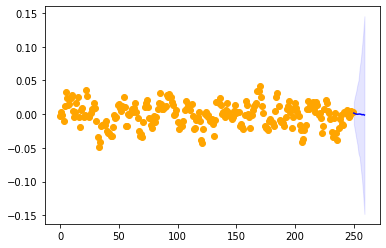

In [19]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(y)), y, 'o', color='orange');
ax.fill_between(np.arange(len(y), len(y)+steps), *numpyro.diagnostics.hpdi(y_pred[:, -steps:]), alpha=.1, color='blue');
ax.plot(np.arange(len(y), len(y)+steps), y_pred[:, -steps:].mean(axis=0), color='blue');

## seasonal arima

Don't know how to generate data, so...let's use the air passengers dataset?

In [20]:
import pandas as pd
df = pd.read_csv('AirPassengers.csv')
step = 10
y = df['#Passengers'].iloc[:-step].to_numpy()

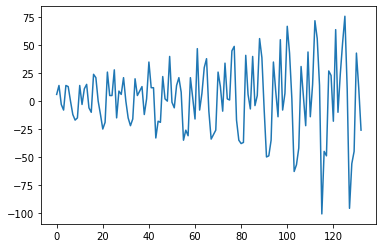

In [21]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot(np.arange(len(y)-1), y[1:]-y[:-1]);

In [22]:
from statsmodels.tsa.stattools import pacf, acf

/Users/marcogorelli/opt/miniconda3/envs/good-bayesian/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/Users/marcogorelli/opt/miniconda3/envs/good-bayesian/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/marcogorelli/opt/miniconda3/envs/good-bayesian/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/Users/marcogorelli/opt/miniconda3/envs/good-bayesian/lib/pyt

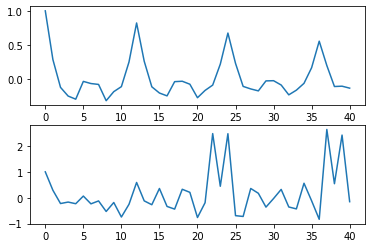

In [23]:
y_diff = y[1:] - y[:-1]
acf_data = acf(y_diff)
pacf_data = pacf(y_diff)

fig, ax = plt.subplots(nrows=2)
ax[0].plot(np.arange(len(acf_data)), acf_data)
ax[1].plot(np.arange(len(pacf_data)), pacf_data)

In [24]:
pacf_data

array([ 1.        ,  0.28747677, -0.22511158, -0.16824778, -0.23208721,
        0.06360802, -0.23699183, -0.12397987, -0.53151111, -0.18521317,
       -0.74616545, -0.25489136,  0.58943184, -0.12179267, -0.27099387,
        0.35627247, -0.33723679, -0.44029923,  0.32638584,  0.20754998,
       -0.76556305, -0.1919763 ,  2.4784282 ,  0.44278704,  2.47387352,
       -0.69354484, -0.72477112,  0.35705198,  0.17100683, -0.36313868,
       -0.03173108,  0.32117191, -0.35820416, -0.43205018,  0.55909469,
       -0.11920355, -0.83464379,  2.63836145,  0.54117831,  2.42078791,
       -0.15338543])

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [26]:
def scale(feat):
    return (feat - np.mean(feat))/np.std(feat)

In [27]:
mod = SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 0, 0, 12))
fit = mod.fit()
fit.summary()

/Users/marcogorelli/opt/miniconda3/envs/good-bayesian/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  134
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -514.544
Date:                             Mon, 02 Aug 2021   AIC                           1037.088
Time:                                     14:13:52   BIC                           1048.650
Sample:                                          0   HQIC                          1041.786
                                             - 134                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5514      0.332     -1.661      0.097      -1.202       0.099
ma.L1          0.3747      0.362      1.035      0.301      -0.335       1.084
ar.S.L12       0.9607      0.021     46.235      0.000       0.920       1.001
sigma2       106.4729     13.289      8.012      0.000      80.426     132.520
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.19
Prob(Q):                              0.99   Prob(JB):                         0.12
Heteroskedasticity (H):               2.30   Skew:                            -0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

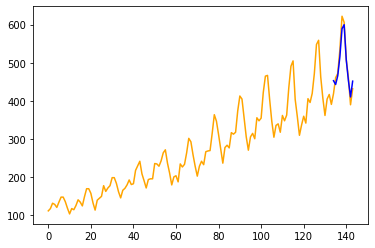

In [28]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(df)), df['#Passengers'], color='orange')
ax.plot(np.arange(len(df)-step, len(df)), fit.forecast(steps=step), color='blue')

In [29]:
def sarima(y):
    alpha = numpyro.sample(
        'alpha',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    phi = numpyro.sample(
        'phi',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    mu = numpyro.sample(
        'mu',
        numpyro.distributions.Normal(0, 1),
    )
    alpha_12 = numpyro.sample(
        'alpha_12',
        numpyro.distributions.TruncatedDistribution(numpyro.distributions.Normal(0, 1), low=-1, high=1),
    )
    
    sigma = numpyro.sample(
        'sigma',
        numpyro.distributions.HalfNormal(1),
    )
    
    def transition_fn(carry, next_y):
        y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8, y_9, y_10, y_11, y_12, y_13, err = carry
        nu = alpha*y_1 + alpha_12*y_12 - alpha*alpha_12*y_13 + phi*err
        err = next_y - nu
        return (next_y, y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8, y_9, y_10, y_11, y_12, err), err
    
    err_0 = y[12] - (mu + phi*mu)
    _, err = jax.lax.scan(
        transition_fn,
        (y[12], y[11], y[10], y[9], y[8], y[7], y[6], y[5], y[4], y[3], y[2], y[1], y[0], err_0),
        y[13:],
    )
    err = jax.numpy.concatenate([err_0[jax.numpy.newaxis], err])
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Normal(0, sigma),
        obs=err,
    )

In [30]:
sampler = numpyro.infer.NUTS(sarima)
mcmc = numpyro.infer.MCMC(sampler, num_samples=1000, num_warmup=1000, num_chains=4)
y_scaled = scale(y_diff)
mcmc.run(jax.random.PRNGKey(0), y=y_scaled)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [31]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.00      0.42      0.00     -0.64      0.69   1141.72      1.00
  alpha_12      0.99      0.01      0.99      0.98      1.00   2771.69      1.00
        mu      0.37      0.50      0.30     -0.40      1.13   1527.71      1.00
       phi     -0.22      0.41     -0.23     -0.88      0.40   1148.39      1.00
     sigma      0.34      0.02      0.34      0.31      0.38   2204.85      1.00

Number of divergences: 1


In [32]:
y_pred = np.ones((4000, len(y_scaled)+steps))*np.hstack([y_scaled, np.zeros(steps)])

In [33]:
steps = len(df)-len(y)
trace = mcmc.get_samples()
for t in range(len(y_scaled), len(y_scaled)+steps):
    err_1 = y_pred[:, t-1] - (trace['alpha'])
    pred = scipy.stats.norm(
        (
            trace['alpha']*y_pred[:, t-1]
            + trace['alpha_12']*y_pred[:, t-12]
            - trace['alpha_12']*trace['alpha']*y_pred[:, t-13]
            + trace['phi']*(y_pred[:, t-1]-y_pred[:, t-1].mean())
        ),
        trace['sigma']).rvs(len(trace['sigma']),
    )
    y_pred[:, t] = pred

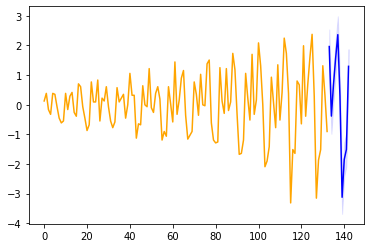

In [34]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(y_scaled)), y_scaled, color='orange');
ax.fill_between(np.arange(len(y_scaled), len(y_scaled)+steps), *numpyro.diagnostics.hpdi(y_pred[:, -steps:]), alpha=.1, color='blue');
ax.plot(np.arange(len(y_scaled), len(y_scaled)+steps), y_pred[:, -steps:].mean(axis=0), color='blue');

In [35]:
y_pred_unscaled = y_pred*np.std(y_diff)+np.mean(y_diff)

In [36]:
restored = [np.ones(4000)*y[0]]
for i in range(y_pred_unscaled.shape[1]):
    restored.append(restored[-1]+y_pred_unscaled[:, i])
restored = np.array(restored).T
restored.shape

(4000, 144)

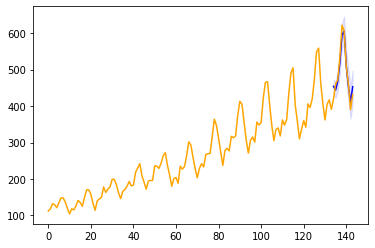

In [37]:
fig, ax = plt.subplots()
ax.fill_between(np.arange(len(y), len(y)+steps), *numpyro.diagnostics.hpdi(restored[:, -steps:]), alpha=.1, color='blue');
ax.plot(np.arange(len(y), len(y)+steps), restored[:, -steps:].mean(axis=0), color='blue');
ax.plot(np.arange(len(df)), df['#Passengers'], color='orange');

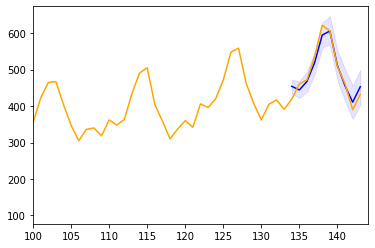

In [38]:
fig, ax = plt.subplots()
ax.fill_between(np.arange(len(y), len(y)+steps), *numpyro.diagnostics.hpdi(restored[:, -steps:]), alpha=.1, color='blue');
ax.plot(np.arange(len(y), len(y)+steps), restored[:, -steps:].mean(axis=0), color='blue');
ax.plot(np.arange(len(df)), df['#Passengers'], color='orange');
ax.set_xlim([100, len(df)]);